# Disseration Experiment 4f
# Generate LIME - IDENTITY + STABILITY Metric November Twenty¶
Ciaran Finnegan November 2023

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

from IPython.display import display, HTML

# Import necessary libraries for ANN model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import necessary libraries for LIME calculations
import lime
import lime.lime_tabular

# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0001 seconds
Result: Result, Execution Time: 2.0001327991485596 seconds


Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

# Data Visualisation and Exploration

## Import Data

In [5]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

### Dataset Structure

In [6]:
# Display the first few rows of the dataset to understand its structure
styled_dataframe(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Generate Visualizations

In [8]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

#### Generate Visualizations to better understand the data distribution and relationships between features.

##### Bar and Box Plot Visualisations

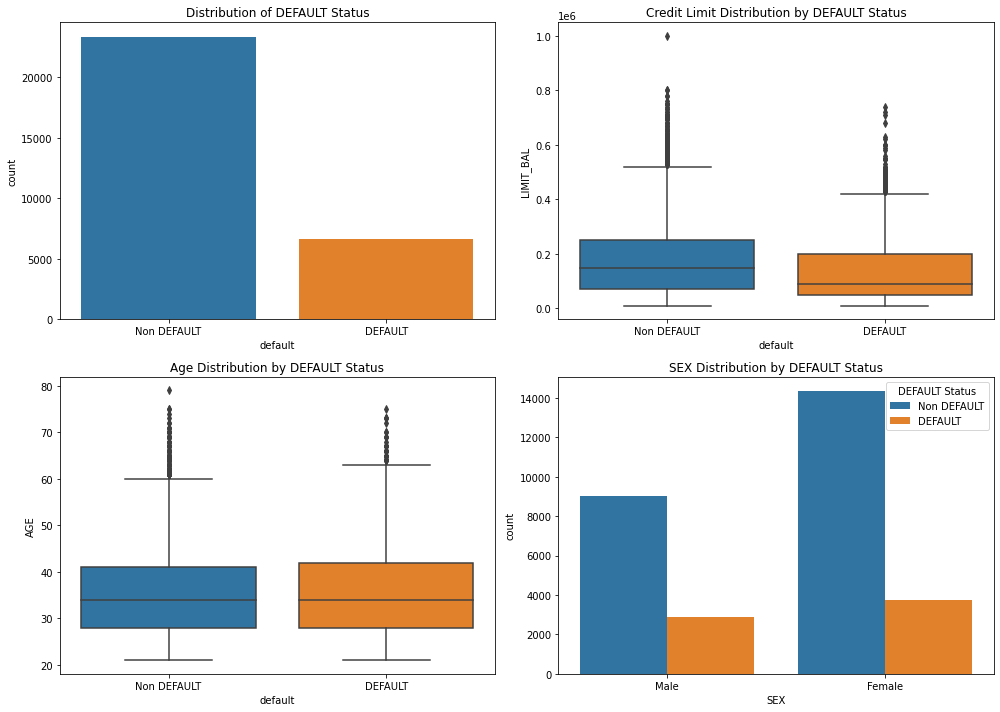

In [9]:
generate_box_plots(df, sTarget_feature, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3,
                       sFeature3_ticklabel1, 
                       sFeature3_ticklabel2)

#### Heatmap Visualisation

In [10]:
# Would need feature reduction to work effectively - or some other filtering

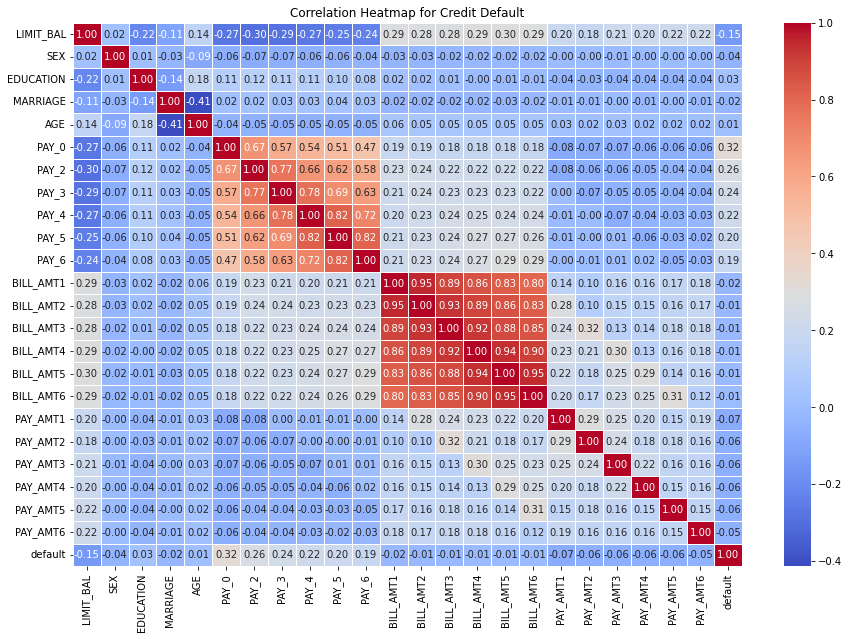

In [11]:
generate_heatmap(df, "Credit Default")

#### Distributions

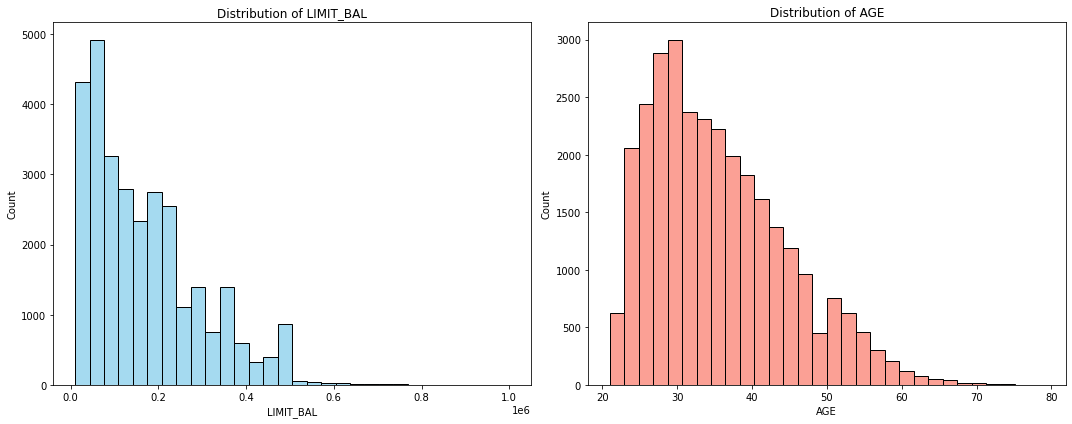

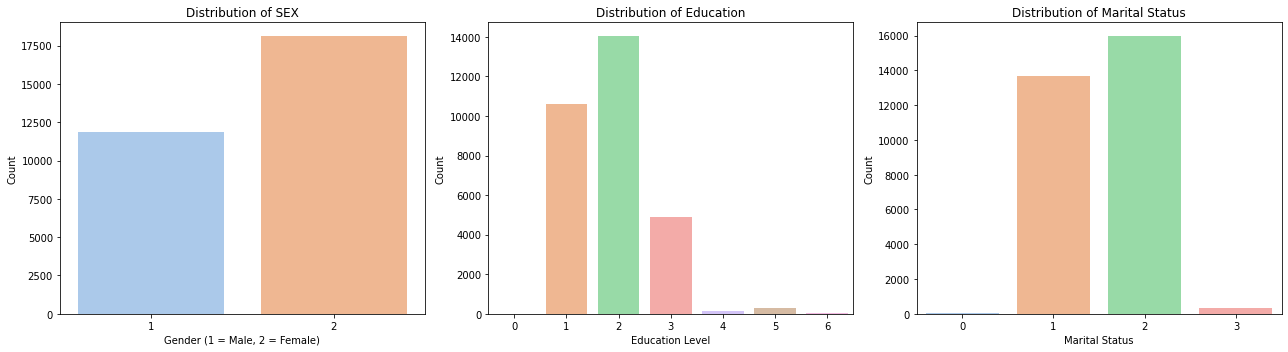

In [12]:
generate_distributions(df, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3)

# Feature Engineering

## Check for Missing Data

In [13]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data


Columns with more than 75% missing values: Index([], dtype='object')


In [14]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Categorical Data 

In [15]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [16]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [17]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [18]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


In [19]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

## Downsample Majority Class

In [20]:
# Check the distribution of the target variable
target_distribution = df_encoded['default'].value_counts()

target_distribution

0    23364
1     6636
Name: default, dtype: int64

In [21]:
# Separate the majority and minority classes
df_majority = df_encoded[df_encoded['default'] == 0]
df_minority = df_encoded[df_encoded['default'] == 1]

In [22]:
# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=target_distribution[1], 
                                   random_state=42)

In [23]:
# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [24]:
# Shuffle the dataset to mix the data points
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
# Display the distribution of the target variable in the downsampled dataset
df_downsampled['default'].value_counts()

0    6636
1    6636
Name: default, dtype: int64

## Split Features + Target

In [26]:
# Features and target variable
X = df_downsampled.drop('default', axis=1)
y = df_downsampled['default']

## Split Data into Test/Training Datasets

In [27]:
# Splitting the data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
# Reset Indexes
X_train_downsampled = X_train_downsampled.reset_index(drop=True)
X_test_downsampled = X_test_downsampled.reset_index(drop=True)

y_train_downsampled = y_train_downsampled.reset_index(drop=True)
y_test_downsampled = y_test_downsampled.reset_index(drop=True)

In [29]:
X_train_downsampled.shape, X_test_downsampled.shape

((10617, 91), (2655, 91))

## Scale The Features

In [30]:
X_train_downsampled.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,160000,44,0,14121,0,0,0,150,14121,0,0,0,150,790,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,230000,38,14887,23751,52698,101007,103598,150430,10000,30000,50000,4691,50000,4000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,30000,39,9884,9586,10318,10522,11354,11022,0,1200,375,1000,0,1000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,200000,27,3592,3622,7990,10392,7042,5692,3622,7990,6000,0,2000,5000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,130000,38,6360,5375,5476,6931,99416,99702,1088,1189,2646,104590,3358,3314,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


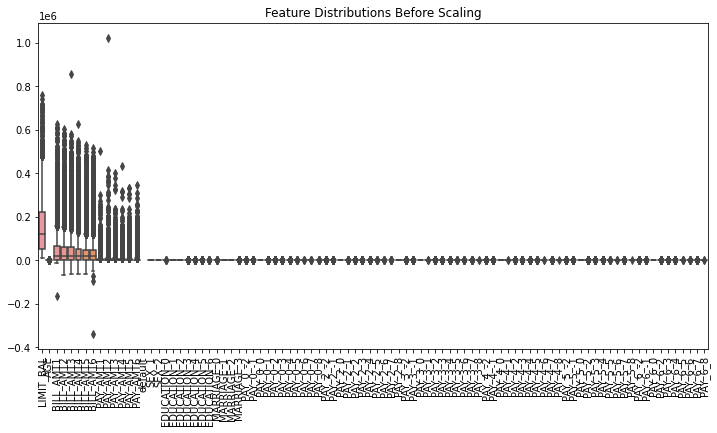

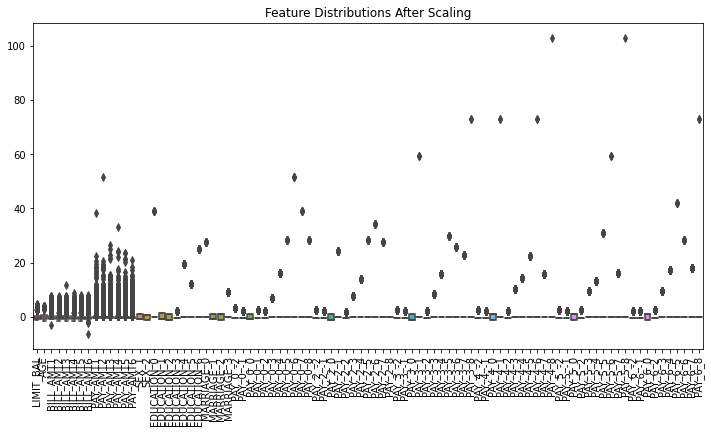

In [31]:
X_train_downsampled, X_test_downsampled = scale_the_features(X_train_downsampled, X_test_downsampled, df_downsampled)

## Basic Additional Data Exploration (Training Data)

In [32]:
# Train model Stats

print("Number of Features:", X_train_downsampled.shape[1])
print("Number Continuous Features:", X_train_downsampled.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train_downsampled.shape[0])
print("Number Positive Train Examples:", (y_train_downsampled == 1).sum())
print("Number Negative Train Examples:", (y_train_downsampled == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 10617
Number Positive Train Examples: 5291
Number Negative Train Examples: 5326


# Build Model

## Set Up Hyperparameters

In [33]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_downsampled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [35]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Build Neural Network (w/TensorFlow/Keras)

In [36]:
# Train the model
history = model.fit(
    X_train_downsampled, y_train_downsampled,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

print("Model trained successfully!")

Epoch 1/20
133/133 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6383 - val_loss: 0.5873 - val_accuracy: 0.6959
Epoch 2/20
133/133 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.6869 - val_loss: 0.5807 - val_accuracy: 0.7048
Epoch 3/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.6920 - val_loss: 0.5741 - val_accuracy: 0.7039
Epoch 4/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5773 - accuracy: 0.7048 - val_loss: 0.5672 - val_accuracy: 0.7057
Epoch 5/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5698 - accuracy: 0.6992 - val_loss: 0.5668 - val_accuracy: 0.7029
Epoch 6/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.7078 - val_loss: 0.5710 - val_accuracy: 0.7006
Epoch 7/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5647 - accuracy: 0.7086 - val_loss: 0.5650 - val_accuracy: 0.7057
Epoch 

# Evaluate Model

## Assess and Display Model Peformance

### Tabular Data

In [37]:
y_pred_funct = display_model_metrics_tabular(model, X_test_downsampled, y_test_downsampled)

83/83 [==============================] - 0s 1ms/step - loss: 0.5678 - accuracy: 0.7058


83/83 [==============================] - 0s 992us/step


Metric,Value
Accuracy,0.705838
ROC AUC Score,0.778400
Precision (Class 0),0.672989
Recall (Class 0),0.785496
F1-Score (Class 0),0.724903
Precision (Class 1),0.750444
Recall (Class 1),0.628253
F1-Score (Class 1),0.683934


Tablular Done!


### Confusion Matrix

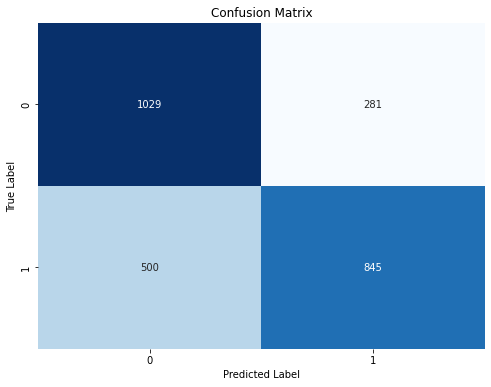

'Confusion Matrix!'

In [38]:
generate_confusion_matrix(y_test_downsampled, y_pred_funct)

# Generate LIME Values

In [39]:
# Importing necessary libraries
import lime
from lime import lime_tabular

In [40]:
X_test_downsampled

array([[ 0.36822805, -0.9135608 , -0.62861507, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [ 2.66890055, -0.59540227, -0.33395329, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-1.05977557, -1.33777218, -0.5910518 , ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       ...,
       [-0.42510729, -0.80750796, -0.6860735 , ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-0.98044203,  0.78328472, -0.47308451, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-1.05977557, -1.33777218, -0.42418342, ..., -0.0350136 ,
        -0.05583828, -0.01372635]])

In [41]:
X_test_downsampled.shape

(2655, 91)

In [42]:
# Extract the feature names, excluding the target variable 'default'
column_names = df_downsampled.drop('default', axis=1).columns

In [43]:
# Convert NumPy array to DataFrame
X_test_downsampled = pd.DataFrame(X_test_downsampled, columns=column_names)

In [44]:
# 1. Choosing an instance for which we want an explanation
instance = X_test_downsampled.iloc[0].values.reshape(1, -1)

In [45]:
# Wrapper function to output probabilities for both classes
def predict_proba_wrapper(data):
    # Get the probability of the positive class
    prob_pos = model.predict(data)
    # Get the probability of the negative class
    prob_neg = 1 - prob_pos
    # Combine and return the probabilities
    return np.hstack([prob_neg, prob_pos])

In [46]:
X_train_downsampled

array([[ 0.05089392,  0.88933756, -0.6860735 , ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [ 0.60622866,  0.25302049, -0.48513769, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-0.98044203,  0.35907334, -0.55266519, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       ...,
       [ 1.63756461,  1.52565463, -0.6860735 , ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-0.9011085 ,  1.84381317, -0.49459937, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-0.02843962, -0.17119089, -0.64424506, ..., -0.0350136 ,
        -0.05583828, -0.01372635]])

In [47]:
X_train_downsampled.shape

(10617, 91)

In [48]:
# Convert NumPy array to DataFrame
X_train_downsampled = pd.DataFrame(X_train_downsampled, columns=column_names)

In [49]:
# 2-5. Creating a LIME explainer
# We use LIME's LimeTabularExplainer for tabular (table) data
# 'training_data' is the data used to train the model, required for LIME to sample perturbations
# 'mode' indicates we're dealing with a classification problem
# 'feature_names' are the names of the columns
explainer = lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                              mode='classification',
                                              training_labels=y_train_downsampled,
                                              feature_names=X_train_downsampled.columns)

In [50]:
# 6. Explaining the prediction using the LIME explainer
# Using our wrapper function for predictions
explanation = explainer.explain_instance(instance[0], predict_proba_wrapper)

157/157 [==============================] - 0s 1ms/step


In [51]:
# Displaying the LIME explanations for the instance
# 'show_in_notebook' displays the explanation in a Jupyter notebook format
explanation.show_in_notebook(show_table=True)

#### Additional Breakout

In [52]:
# Create a LIME explainer object with a new name
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                                        feature_names=X_train_downsampled.columns.tolist(), 
                                                        class_names=['Not Default', 'Default'], 
                                                        mode='classification')

In [53]:
# Adjusting the prediction function to ensure it provides probabilities for both classes
def predict_fn(data):
    prob_pos = model.predict(data)
    prob_neg = 1 - prob_pos
    return np.hstack([prob_neg, prob_pos])

In [54]:
def detailed_explanation(instance, real_value):
    """
    Generate LIME explanation for a specific instance and provide a detailed narrative.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    # Adjusting the prediction function to ensure it provides probabilities for both classes
    #def predict_fn(data):
    #    prob_pos = model.predict(data)
    #    prob_neg = 1 - prob_pos
    #    return np.hstack([prob_neg, prob_pos])

    # Get the prediction for the instance
    prediction_probs = predict_fn(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance using the modified prediction function
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(X_train_downsampled.columns))
    
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Default): {prediction_probs[0][1]:.2f}\n')
    print('Features in Order of Importance:')
    for feature, weight in sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True):
        feature_parts = feature.split(' ')
        feature_name = feature_parts[0]
        feature_value = ' '.join(feature_parts[1:])
        print(f'Feature: {feature_name} | Value: {feature_value} | Weight: {weight:.2f}')
    print('----------------------------------------\n\n')
    
    return exp

# The function is now ready to be used. When called, it will provide a detailed explanation for a given instance.


In [55]:
# Generating LIME explanations for the first three values in the test dataset
for i in range(5):
    instance = X_test_downsampled.iloc[i].values
    real_value = y_test_downsampled.iloc[i]
    detailed_explanation(instance, real_value)

157/157 [==============================] - 0s 991us/step


----------------------------------------
Real Value: 1
Predicted Probability (Default): 0.37

Features in Order of Importance:
Feature: PAY_0_3 | Value: <= -0.14 | Weight: -0.38
Feature: PAY_0_7 | Value: <= -0.03 | Weight: -0.37
Feature: EDUCATION_0 | Value: <= -0.03 | Weight: 0.35
Feature: PAY_0_5 | Value: <= -0.04 | Weight: -0.35
Feature: PAY_6_5 | Value: <= -0.02 | Weight: -0.35
Feature: PAY_2_5 | Value: <= -0.04 | Weight: -0.33
Feature: PAY_4_8 | Value: <= -0.01 | Weight: -0.33
Feature: PAY_2_7 | Value: <= -0.04 | Weight: -0.32
Feature: PAY_3_8 | Value: <= -0.01 | Weight: -0.32
Feature: PAY_3_5 | Value: <= -0.03 | Weight: -0.31
Feature: PAY_5_6 | Value: <= -0.02 | Weight: -0.26
Feature: PAY_5_7 | Value: <= -0.06 | Weight: -0.24
Feature: PAY_5_8 | Value: <= -0.01 | Weight: -0.23
Feature: PAY_0_2 | Value: <= -0.43 | Weight: -0.23
Feature: PAY_4_7 | Value: <= -0.06 | Weight: -0.23
Feature: EDUCATION_5 | Value: <= -0.08 | Weigh

Narrative:

For each instance, the output will display the features in order of their importance in determining the predicted probability.

For the instance with a real default value of 1:

If the predicted probability of defaulting is high, this means the model recognizes patterns in this instance similar to other defaulting instances from the training data.

Features with positive weights contributed to increasing the probability of a default prediction. The larger the weight, the more influential that feature was.

Conversely, features with negative weights worked against the default prediction. The larger the negative weight, the more it tried to reduce the probability.




For the two instances with a real default value of 0:

If the predicted probability of defaulting is low, this means the model recognizes patterns in this instance similar to other non-defaulting instances from the training data.

Again, positive weights indicate features that tried to push the prediction towards a default, while negative weights indicate features that tried to push the prediction away from a default.




For each feature displayed, the "Value" tells you what the specific value of that feature was for the instance, and the "Weight" tells you how much that feature influenced the prediction. By examining the top features and their weights, you can get a good understanding of why the model made its prediction.







#### Check why Prediction Probabilities are always the same...

In [56]:
# 1. Direct Evaluation
sample_instance = X_test_downsampled.iloc[0].values.reshape(1, -1)
print("Direct model prediction:", model.predict(sample_instance))
print("predict_fn output:", predict_fn(sample_instance))

# 2. Check Output Shape
assert predict_fn(sample_instance).shape == (1, 2), "Output shape of predict_fn is incorrect!"

# 3. Check Probability Sum
probabilities = predict_fn(sample_instance)
assert abs(probabilities[0].sum() - 1) < 1e-6, "Probabilities do not sum to 1!"

# 4. Visual Inspection
print("\nVisual inspection of predict_fn outputs for first 5 test instances:")
for i in range(5):
    instance = X_test_downsampled.iloc[i].values.reshape(1, -1)
    print(f"Instance {i}: {predict_fn(instance)}")

1/1 [==============================] - 0s 20ms/step
Direct model prediction: [[0.37058285]]
1/1 [==============================] - 0s 19ms/step
predict_fn output: [[0.6294172  0.37058285]]
1/1 [==============================] - 0s 18ms/step

Visual inspection of predict_fn outputs for first 5 test instances:
1/1 [==============================] - 0s 18ms/step
Instance 0: [[0.6294172  0.37058285]]
1/1 [==============================] - 0s 19ms/step
Instance 1: [[0.89411014 0.10588986]]
1/1 [==============================] - 0s 23ms/step
Instance 2: [[0.10088295 0.89911705]]
1/1 [==============================] - 0s 19ms/step
Instance 3: [[0.7437273  0.25627267]]
1/1 [==============================] - 0s 19ms/step
Instance 4: [[0.71892345 0.28107655]]


# Prepare LIME Values for Metrics

## Format for Identity + Stability Metrics

To achieve your goal, we need to:

Generate explanations for the chosen instances.
Create dataframes for the individual instance features and their corresponding LIME values/weights.
Ensure consistent structure for the LIME values/weights dataframe.
Save the dataframes to output files.
Given the specific structure you need for the LIME values/weights dataframe, we'll also have to ensure that each feature has a consistent number of columns across all instances.

Let's proceed:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

In [57]:
# Choose instances as per the given conditions
#default_1_indices = y_test[y_test == 1].index
#default_0_indices = y_test[y_test == 0].index

#_downsampled
default_1_indices = y_test_downsampled[y_test_downsampled == 1].index
default_0_indices = y_test_downsampled[y_test_downsampled == 0].index


chosen_indices = list(np.random.choice(default_1_indices, 10)) \
                                + list(np.random.choice(default_0_indices, 25))

# Lists to store instance features and LIME values/weights
#features_data = []
#lime_data = []

The get_detailed_explanation function generates LIME explanations for an instance 
and returns the feature values and LIME values/weights.

In [58]:
# Function to get LIME explanations for an instance, modified to return explanations rather than print
def get_detailed_explanation(instance):
    """
    Generate LIME explanation for a specific instance.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    
    Returns:
    - feature_values (list): List of feature values for the instance.
    - lime_values (list): List of tuples containing LIME values and weights for the instance.
    """
    # Generate LIME explanation for the instance
    #exp = lime_explainer.explain_instance(instance, model.predict_proba, num_features=6)
    #exp = lime_explainer.explain_instance(instance, model.predict, num_features=6)
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=6) #num_features=len(X_train_downsampled.columns))

    
    feature_values = instance.tolist()
    lime_values = exp.as_list()
    
    return feature_values, lime_values

We then loop over the chosen instances, get their feature values and 
LIME explanations, and store them in lists.

In [59]:
@timeit
def generate_lime_explanations(df):
    
    # Lists to store instance features and LIME values/weights
    features_data = []
    lime_data = []

    # Generate explanations for the chosen instances
    for index in chosen_indices:
        #feature_values, lime_values = get_detailed_explanation(X_test.loc[index].values)
        #feature_values, lime_values = get_detailed_explanation(X_test_downsampled.loc[index].values)
        feature_values, lime_values = get_detailed_explanation(df.loc[index].values)
        features_data.append(feature_values)
        lime_data.append(lime_values)

    # Convert features data to a DataFrame
    features_df = pd.DataFrame(features_data, columns=X_train_downsampled.columns.tolist())

    # Ensure consistent structure for the LIME values/weights dataframe
    max_columns = max(len(lime_values) for lime_values in lime_data) * 2  # Multiply by 2 to account for values and weights
    lime_array = []

    for lime_values in lime_data:
        lime_values_array = []
        for feature, weight in lime_values:
            lime_values_array.extend([feature, weight])
        # Padding to ensure consistent number of columns
        lime_values_array.extend([None] * (max_columns - len(lime_values_array)))
        lime_array.append(lime_values_array)

    lime_df = pd.DataFrame(lime_array)
    
    return features_df, lime_df

The feature values are straightforwardly converted to a dataframe.
For the LIME values/weights dataframe, we ensure a consistent number of columns 
across all instances by determining the maximum number of columns needed (max_columns) 
and then padding each instance's LIME values/weights with None values to match this maximum.

In [60]:
# When calling the function, you get both the results and the execution time
# Call the function with the custome decorator for time measurement
results, exec_time = generate_lime_explanations(X_test_downsampled)

157/157 [==============================] - 0s 964us/step
Function 'generate_lime_explanations' executed in 468.6979 seconds


In [61]:
# Unpack the results to get features_df, lime_df
features_df, lime_df = results

## Determine Computational Efficiency Value

In [62]:
# Display time to generate LIME explainers
print(f"LIME Execution Time: {exec_time} seconds")

LIME Execution Time: 468.6978600025177 seconds


In [63]:
# Save the dataframes to output files
features_df.to_csv('lime_instance_features.csv', index=False)
lime_df.to_csv('lime_values_weights.csv', index=False)

Finally, we save the dataframes to output files.

Comments:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

The get_detailed_explanation function generates LIME explanations for an instance and returns the feature values and LIME values/weights.

We then loop over the chosen instances, get their feature values and LIME explanations, and store them in lists.

The feature values are straightforwardly converted to a dataframe.

For the LIME values/weights dataframe, we ensure a consistent number of columns across all instances by determining the maximum number of columns needed (max_columns) and then padding each instance's LIME values/weights with None values to match this maximum.

Finally, we save the dataframes to output files.

Note: Ensure you run the previous code sections (including importing libraries and defining the lime_explainer) before executing this code in your Kubeflow Notebook.

In [64]:
def euclidean_distance(instance1, instance2):
    """
    Compute the Euclidean distance between two instances, considering only numerical columns.
    
    Parameters:
    - instance1 (pd.Series): The first instance.
    - instance2 (pd.Series): The second instance.
    
    Returns:
    - float: The Euclidean distance between the two instances.
    """
    # Filter out non-numerical columns
    instance1_numeric = instance1[instance1.apply(lambda x: np.isreal(x) and not isinstance(x, bool))]
    instance2_numeric = instance2[instance2.apply(lambda x: np.isreal(x) and not isinstance(x, bool))]
    
    return np.sqrt(np.sum((instance1_numeric - instance2_numeric) ** 2))

In [65]:
# Select two random instances from the LIME dataframe
random_indices = np.random.choice(lime_df.index, size=2, replace=False)
instance_1 = lime_df.iloc[random_indices[0]]
instance_2 = lime_df.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances
distance = euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")

Euclidean distance between instance 17 and instance 25: 0.0314


# Generate XAI Metrics 

## Identity

## Identity Metric Function

#### Run a Basic Test First

In [66]:
# Select two random instances from the LIME dataframe
random_indices = np.random.choice(lime_df.index, size=2, replace=False)
instance_1 = lime_df.iloc[random_indices[0]]
instance_2 = lime_df.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances
distance = get_euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")


Calculating Euclidean distance...


Euclidean distance between instance 27 and instance 8: 0.4513


#### Retrieve Identity Score

In [67]:
# LIME Values need to limited to Numeric
xai_values_df_numeric = lime_df.select_dtypes(include=[np.number])

In [68]:
from scipy.spatial import distance

In [69]:
LIME_Identity_Metric = get_identity_metric(features_df, xai_values_df_numeric, "LIME")

Instance 0:   Current matches: 0
	Closest feature instance: 21 (Distance: 3.0569)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 1:   Current matches: 0
	Closest feature instance: 31 (Distance: 4.6914)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 2:   Current matches: 0
	Closest feature instance: 1 (Distance: 11.2930)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 3:   Current matches: 0
	Closest feature instance: 30 (Distance: 7.8679)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 4:   Current matches: 0
	Closest feature instance: 22 (Distance: 3.6668)
	Closest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 5:   Current matches: 0
	Closest feature instance: 28 (Distance: 6.0380)
	Closest LIME instance: {closest_xai_idx} (Distance: 

#### Display Identity Score Metric

In [70]:
LIME_Identity_Number = "{:.2f}%".format(LIME_Identity_Metric)

In [71]:
display_text("LIME Identity Metric Score: " + LIME_Identity_Number)

## Stability

### Invoke Stability Metric Function

#### Retrieve Stability Score

In [75]:
LIME_Stability_Metric = get_stability_metric_y(xai_values_df_numeric, y_test_downsampled, 'LIME')

Number of Instances in Cluster '0': 0
Number of Instances in Cluster '1': 0

For Class '0':
Total Instances: 16
Matching Cluster '0' Instances: 0

For Class '1':
Total Instances: 19
Matching Cluster '1' Instances: 0


This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- LIME



Percentage of matches: 0.00%   0.0 Matches of 35 Entries


#### Display Stability Score Metric

In [76]:
LIME_Stability_Number = "{:.2f}%".format(LIME_Stability_Metric)

In [77]:
display_text("SHAP Stability Metric Score: " + LIME_Stability_Number)

## Seperability

### Invoke Seperability Metric Function

#### Retrieve Seperability Score

In [80]:
LIME_Seperability_Metric = get_seperability_metric(features_df, xai_values_df_numeric, "LIME")

#### Display Seperability Score Metric

In [81]:
LIME_Seperability_Number = "{:.2f}%".format(LIME_Seperability_Metric)

In [82]:
display_text("LIME Seperability Metric Score: " + LIME_Seperability_Number)

## Similarity

### Invoke Similarity Metric Function

#### Retrieve Similarity Score

In [83]:
LIME_Similarity_Metric = get_similarity_metric(features_df, xai_values_df_numeric, "LIME", use_dbscan=False)

#### Display Similarity Score Metric

In [84]:
LIME_Similarity_Number = "{:6.2f}".format(LIME_Similarity_Metric)

In [85]:
display_text("LIME Similarity Metric Value: " + LIME_Similarity_Number)